# Stitching many images into panorama

OpenCV has a lot of Computer Vision algorithms. Some of them are lowlevel, while others are used in special cases. But there is functionality, which joins many algorithms together using everyday applications. One of these pipelines is panorama stitching. This rather complicated procedure can be done easily in OpenCV and gives decent results. This recipe shows you how to use OpenCV tools to create your own panorama.

`cv2.createStitcher` builds an instance of the panorama stitching algorithm. To apply it to the panorama creation, you need to call its stitch method. This method accepts an array of images to combine, and returns a stitching result status as well as a panorama image. The status may have one of the following values:

* `cv2.STITCHER_OK`
* `cv2.STITCHER_ERR_NEED_MORE_IMGS`
* `cv2.STITCHER_ERR_HOMOGRAPHY_EST_FAIL`
* `cv2.STITCHER_ERR_CAMERA_PARAMS_ADJUST_FAIL`

The first value means the panorama was successfully created. The other values tell you that the panorama wasn't composed and gives you some hints about possible reasons.

The success of the stitching depends on the input images. They should have overlapping regions. The more overlapping areas there are, the easier it is for the algorithm to match the frames and correctly map them to the final panorama. Also, it's better to have photos from a camera that rotates. Small movements of the camera are fine, but undesirable.

In [1]:
# Import all of the necessary modules
import cv2
import matplotlib.pyplot as plt
import numpy as np
import imutils
import os

%matplotlib auto
%pylab inline

def print_image(header,name,np_arr,
                start_First=0,end_First=1,start_Second=0,end_Second=2,start_3=0,end_3=5):
    print("------  {0:-<25}    Shape{1} {2}: {3:}".format(header, np_arr.shape, name, str(np_arr.dtype)) )
    shapes = np_arr.shape #print(shapes)
    if shapes[0] < end_First:
        end_First = shapes[0]
    if shapes[1] < end_Second:
        end_Second = shapes[1]
    if len(shapes)==3:
        if shapes[2] < end_3:
            end_3 = shapes[2]
    if len(shapes)==3:
        for i in range (start_First,end_First):
            print("[", sep='',end="")
            for j in range (start_Second,end_Second):
                print(np_arr[i,j,start_3:end_3], sep=' ', end=" ")
            print(']')
    if len(shapes)==2:
        for i in range (start_First,end_First):
            print("[", end=" ")
            #print(np_arr[i,start_Second:end_Second],sep=' ',end=" ") cutoff sting by<60
            for k in range (start_Second,end_Second):
                print(np_arr[i,k], end=" ")
            print(']')

def draw_grid(img, pxystep=None,major_color=None, pxstep=None,pystep=None):
    #print("{0} XY{1} color{2} X{3} Y{4}".format(img.shape, pxystep,major_color,pxstep,pystep))
    pXYstep = None; pXstep=None; pYstep=None; 
    major_Color=None; minor_Color=None; major_Alpha=None; minor_Alpha=None;
    if pxystep != None:
        pXYstep = pXstep = pYstep = pxystep;
    else:
        pXstep = pxstep if pxstep != None else 100
        pYstep = pystep if pystep != None else 100
    major_Color = major_color if major_color != None else (204, 204, 204) #'#CCCCCC'
    if pXstep != None:
        x = pXstep
        #Draw all lines on X
        while x < img.shape[1]:
            cv2.line(img, (x, 0), (x, img.shape[0]), color=major_Color, thickness=1)
            x += pXstep
    if pYstep != None:
        y = pYstep
        #Draw all lines on Y
        while y < img.shape[0]:
            cv2.line(img, (0, y), (img.shape[1], y), color=major_Color,thickness=1)
            y += pYstep
    return img

def plt_view_image(plt,list_images,figsize=(15,6), axis="off", cmap='gray'):
    plt.figure(figsize=figsize)
    n = len(list_images)  #; print(n)
    plot_number = 1
    for name, img in list_images:
        plt.subplot(1,n,plot_number)
        plt.axis(axis); plt.title(name)
        if cmap =='gray': plt.imshow(img,cmap='gray' )
        else: plt.imshow(img)
        plot_number = plot_number + 1
    plt.show()

def plt_view_grid(plt, axis ='off',
                  xy_sizeaxis =None,
                  xy_measuare =None,
                  x_min=-10, x_max=10, y_min=-10, y_max=10,
                  x_major_size=1, x_minor_size=0.2, y_major_size=1, y_minor_size=0.2,
                  major_color='#CCCCCC', major_alpha=0.5,
                  minor_color='#CCCCCC', minor_alpha=0.2
                 ):
    if xy_sizeaxis is None:  x_min=-10; x_max=10; y_min=-10; y_max=10;
    else: x_min, x_max, y_min, y_max = xy_sizeaxis

    if xy_measuare is None:  x_major_size=1; x_minor_size=0.2; y_major_size=1; y_minor_size=0.2;
    else: x_major_size, x_minor_size, y_major_size, y_minor_size = xy_measuare
        
    plt.xlim(x_min, x_max); plt.ylim(y_min, y_max);
    ax = plt.gca()
    x_major_ticks=np.arange(x_min,x_max,x_major_size); x_minor_ticks=np.arange(x_min,x_max,x_minor_size)
    y_major_ticks=np.arange(y_min,y_max,y_major_size); y_minor_ticks=np.arange(y_min,y_max,y_minor_size)
    ax.set_xticks(x_major_ticks)
    ax.xaxis.set_major_locator(MultipleLocator(x_major_size))
    ax.set_xticks(x_minor_ticks, minor=True)
    ax.set_yticks(y_major_ticks)
    ax.yaxis.set_major_locator(MultipleLocator(y_major_size))
    ax.set_yticks(y_minor_ticks, minor=True)
    plt.grid(which='major', color=major_color, alpha=major_alpha)
    plt.grid(which='minor', color=minor_color, alpha=minor_alpha)
    
#help("modules")   
import sys             
print('\n'.join(sys.path))
print("current folder ==",os.getcwd())
#pip list

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib
D:\HTML_DOC\Program\opencv\Packt\S08\env
C:\Program Files\Python38\python38.zip
C:\Program Files\Python38\DLLs
C:\Program Files\Python38\lib
C:\Program Files\Python38
d:\html_doc\program\opencv\packt\s08\env

d:\html_doc\program\opencv\packt\s08\env\lib\site-packages
d:\html_doc\program\opencv\packt\s08\env\lib\site-packages\pip-20.1b1-py3.8.egg
d:\html_doc\program\opencv\packt\s08\env\lib\site-packages\win32
d:\html_doc\program\opencv\packt\s08\env\lib\site-packages\win32\lib
d:\html_doc\program\opencv\packt\s08\env\lib\site-packages\Pythonwin
d:\html_doc\program\opencv\packt\s08\env\lib\site-packages\IPython\extensions
C:\Users\polit\.ipython
current folder == D:\HTML_DOC\Program\opencv\Packt\S08\env


### Load the images we're going to combine into a panorama:

------  data/panorama/0.jpg------    Shape(2304, 4096, 3) img0_orig: uint8
[[224 220 215] [223 219 214] [223 219 214] [224 220 215] [224 220 215] [224 220 215] [224 221 217] ]
[[226 220 215] [225 219 214] [223 219 214] [223 219 214] [222 218 213] [222 218 213] [223 220 215] ]
------  data/panorama/1.jpg------    Shape(2304, 4096, 3) img1_orig: uint8
[[105 100  91] [105 100  91] [105  99  92] [101  95  88] [107  99  92] [108 100  93] [107  99  92] ]
[[108 102  95] [111 105  98] [109 103  96] [108 102  95] [109 101  94] [113 105  98] [111 103  96] ]
------  img0_resize--------------    Shape(562, 1000, 3) img0_resize: uint8
[[235 207 198] [230 204 191] [231 206 190] [230 205 188] [227 203 185] [229 205 186] [228 205 184] ]
[[231 206 193] [229 206 190] [228 206 188] [227 204 187] [228 206 188] [228 207 186] [224 203 182] ]
------  img1_resize--------------    Shape(562, 1000, 3) img1_resize: uint8
[[125 102 108] [123 103 108] [124 107 115] [167 162 169] [191 193 197] [195 196 199] [193 19

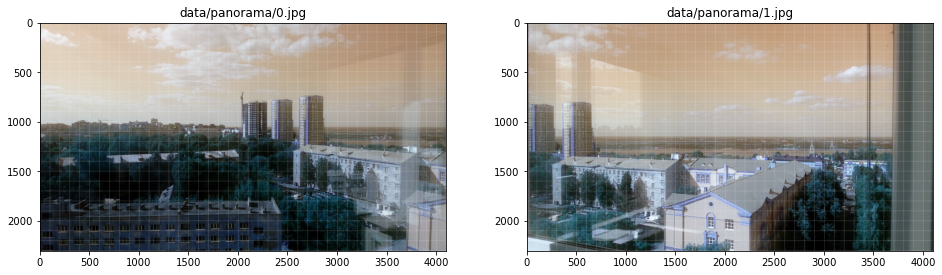

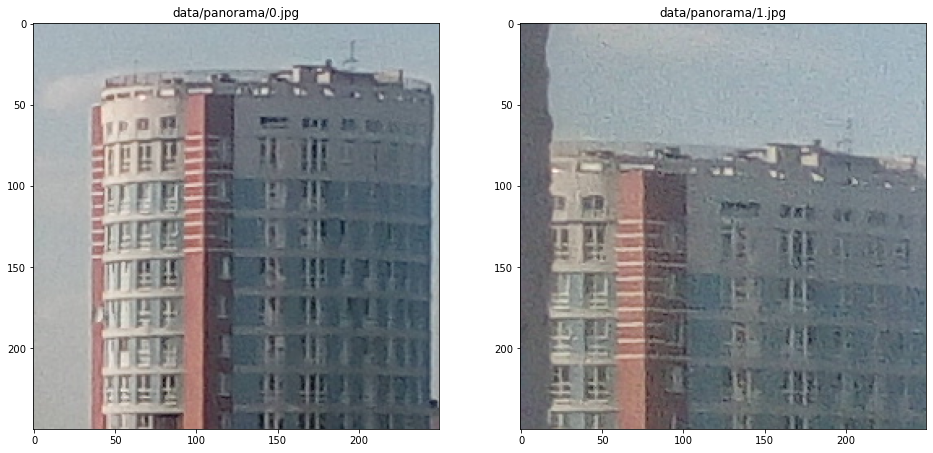

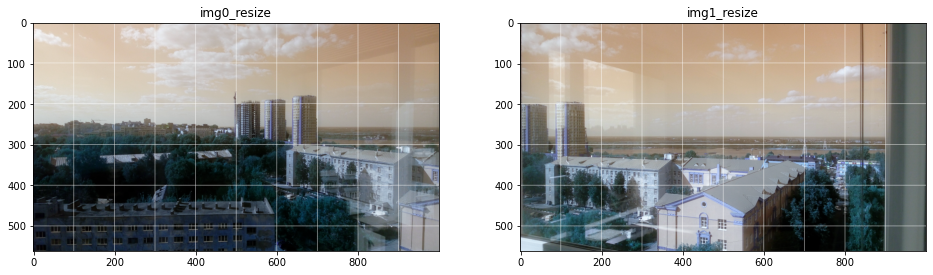

In [2]:
img0_orig = cv2.imread('data/panorama/0.jpg', cv2.IMREAD_COLOR)
img1_orig = cv2.imread('data/panorama/1.jpg', cv2.IMREAD_COLOR)


#####################################################################
img0_resize = imutils.resize(img0_orig, width=1000)
img1_resize = imutils.resize(img1_orig, width=1000)

print_image('data/panorama/0.jpg','img0_orig',draw_grid(np.copy(img0_orig),100,(255,255,255)),750,752,0,7)
print_image('data/panorama/1.jpg','img1_orig',draw_grid(np.copy(img1_orig),100,(255,255,255)),750,752,0,7)
print_image('img0_resize','img0_resize',draw_grid(np.copy(img0_resize),100,(255,255,255)),0,2,0,7)
print_image('img1_resize','img1_resize',draw_grid(np.copy(img1_resize),100,(255,255,255)),0,2,0,7)


plt_view_image(plt,[["data/panorama/0.jpg", draw_grid(np.copy(img0_orig),100,(255,255,255))],
                    ["data/panorama/1.jpg", draw_grid(np.copy(img1_orig),100,(255,255,255))]],
               figsize=(16,8), axis='on', cmap='gray')
plt_view_image(plt,[["data/panorama/0.jpg", img0_orig[750:1000,2300:2550,[2,1,0]]],
                    ["data/panorama/1.jpg", img1_orig[750:1000,0:250,[2,1,0]]]],
               figsize=(16,8), axis='on', cmap='gray')

plt_view_image(plt,[["img0_resize", draw_grid(np.copy(img0_resize),100,(255,255,255))],
                    ["img1_resize", draw_grid(np.copy(img1_resize),100,(255,255,255))]],
               figsize=(16,8), axis='on', cmap='gray')

cv2.imshow('img0_resize, img1_resize', np.hstack((draw_grid(np.copy(img0_resize),100,(255,255,255)),
                                                  draw_grid(np.copy(img1_resize),100,(255,255,255)))))
cv2.waitKey()
cv2.destroyAllWindows()

### Create a panorama stitcher, pass your images to it, and parse the result:

len(imgs)=2 [(56, 100, 3), (56, 100, 3)]
cv2.STITCHER_OK == 0
Error during stitching
len(imgs)=2 [(112, 200, 3), (112, 200, 3)]
cv2.STITCHER_OK == 0
Error during stitching
len(imgs)=2 [(168, 300, 3), (168, 300, 3)]
cv2.STITCHER_OK == 0
Error during stitching
len(imgs)=2 [(225, 400, 3), (225, 400, 3)]
cv2.STITCHER_OK == 0
Error during stitching
len(imgs)=2 [(281, 500, 3), (281, 500, 3)]
cv2.STITCHER_OK == 0
Error during stitching
len(imgs)=2 [(337, 600, 3), (337, 600, 3)]
cv2.STITCHER_OK == 0
Error during stitching
len(imgs)=2 [(393, 700, 3), (393, 700, 3)]
cv2.STITCHER_OK == 0


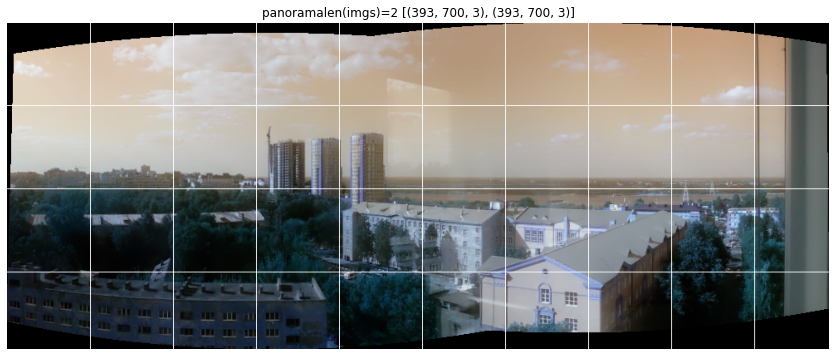

len(imgs)=2 [(450, 800, 3), (450, 800, 3)]
cv2.STITCHER_OK == 0
Error during stitching
len(imgs)=2 [(506, 900, 3), (506, 900, 3)]
cv2.STITCHER_OK == 0
Error during stitching
len(imgs)=2 [(562, 1000, 3), (562, 1000, 3)]
cv2.STITCHER_OK == 0
Error during stitching
len(imgs)=2 [(618, 1100, 3), (618, 1100, 3)]
cv2.STITCHER_OK == 0
Error during stitching
len(imgs)=2 [(675, 1200, 3), (675, 1200, 3)]
cv2.STITCHER_OK == 0


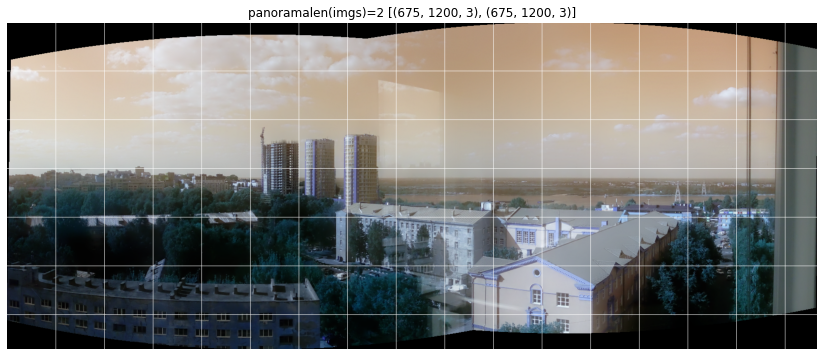

len(imgs)=2 [(731, 1300, 3), (731, 1300, 3)]
cv2.STITCHER_OK == 0
Error during stitching
len(imgs)=2 [(787, 1400, 3), (787, 1400, 3)]
cv2.STITCHER_OK == 0
Error during stitching
len(imgs)=2 [(843, 1500, 3), (843, 1500, 3)]
cv2.STITCHER_OK == 0
Error during stitching
len(imgs)=2 [(900, 1600, 3), (900, 1600, 3)]
cv2.STITCHER_OK == 0
Error during stitching
len(imgs)=2 [(956, 1700, 3), (956, 1700, 3)]
cv2.STITCHER_OK == 0
Error during stitching
len(imgs)=2 [(1012, 1800, 3), (1012, 1800, 3)]
cv2.STITCHER_OK == 0
Error during stitching
len(imgs)=2 [(1068, 1900, 3), (1068, 1900, 3)]
cv2.STITCHER_OK == 0
Error during stitching
len(imgs)=2 [(1125, 2000, 3), (1125, 2000, 3)]
cv2.STITCHER_OK == 0
Error during stitching
len(imgs)=2 [(1181, 2100, 3), (1181, 2100, 3)]
cv2.STITCHER_OK == 0
Error during stitching
len(imgs)=2 [(1237, 2200, 3), (1237, 2200, 3)]
cv2.STITCHER_OK == 0
Error during stitching
len(imgs)=2 [(1293, 2300, 3), (1293, 2300, 3)]
cv2.STITCHER_OK == 0
Error during stitching


In [3]:
for i in range(100, img0_orig.shape[0], 100):
    img0_tmp = imutils.resize(img0_orig, width=i)
    img1_tmp = imutils.resize(img1_orig, width=i)
    imgs =[]
    imgs.append(img0_tmp)
    imgs.append(img1_tmp)
    str_measure = "len(imgs)={0} {1}".format(len(imgs), [i.shape for i in imgs])
    print(str_measure)
    stitcher = cv2.Stitcher.create()
    # Use stitcher to stitch the array of images
    ret, pano = stitcher.stitch(imgs)
    print("cv2.STITCHER_OK ==",cv2.STITCHER_OK)
    
    #print(ret, pano,cv2.STITCHER_OK)
    if ret == cv2.STITCHER_OK:
        #pano = imutils.resize(pano, width=800)
        plt_view_image(plt,[["panorama"+str_measure  ,draw_grid(np.copy(pano),100,(255,255,255))]])
        
        cv2.imshow('panorama', pano)
        cv2.waitKey()
        cv2.destroyAllWindows()
    else:
        print('Error during stitching')

### [MareArts blog / Computer Vision & Artificial Intelligent Systems](http://study.marearts.com/2013/11/opencv-stitching-example-stitcher-class.html)

### OpenCV Stitching example (Stitcher class, Panorama)

------  data/panorama/s1.jpg-----    Shape(320, 213, 3) s1: uint8
[[133 128 127] [130 125 124] [128 123 122] [129 123 124] [131 125 126] [132 125 128] [130 123 126] ]
[[129 124 125] [127 122 123] [126 121 123] [127 122 124] [129 124 126] [129 123 128] [127 121 126] ]
------  data/panorama/s2.jpg-----    Shape(320, 213, 3) s2: uint8
[[153 147 142] [150 144 139] [145 138 135] [138 130 130] [130 121 124] [123 113 119] [118 107 115] ]
[[156 147 143] [156 147 143] [156 147 144] [155 145 145] [155 144 146] [154 143 146] [154 143 146] ]


<Figure size 1080x216 with 0 Axes>

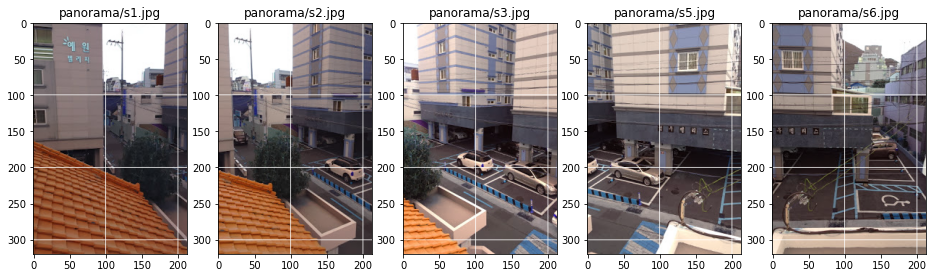

In [4]:
#http://study.marearts.com/2013/11/opencv-stitching-example-stitcher-class.html
img_original1 = cv2.imread('data/panorama/s1.jpg', cv2.IMREAD_COLOR)
img_original2 = cv2.imread('data/panorama/s2.jpg', cv2.IMREAD_COLOR)
img_original3 = cv2.imread('data/panorama/s3.jpg', cv2.IMREAD_COLOR)
img_original5 = cv2.imread('data/panorama/s5.jpg', cv2.IMREAD_COLOR)
img_original6 = cv2.imread('data/panorama/s6.jpg', cv2.IMREAD_COLOR)


#####################################################################
print_image('data/panorama/s1.jpg','s1',img_original1,0,2,0,7)
print_image('data/panorama/s2.jpg','s2',img_original2,0,2,0,7)

plt.figure(figsize=(15,3))
plt_view_image(plt,[["panorama/s1.jpg",draw_grid(np.copy(img_original1),100,(255,255,255))],
                    ["panorama/s2.jpg",draw_grid(np.copy(img_original2),100,(255,255,255))],
                    ["panorama/s3.jpg",draw_grid(np.copy(img_original3),100,(255,255,255))],
                    ["panorama/s5.jpg",draw_grid(np.copy(img_original5),100,(255,255,255))],
                    ["panorama/s6.jpg",draw_grid(np.copy(img_original6),100,(255,255,255))] ],
              figsize=(16,8), axis='on', cmap='gray')

### Add the images to images array

In [5]:
images = []
images.append(img_original1)
images.append(img_original2)
images.append(img_original3)
images.append(img_original5)
images.append(img_original6)
print(len(images), [i.shape for i in images])

5 [(320, 213, 3), (320, 213, 3), (320, 213, 3), (320, 213, 3), (320, 213, 3)]


### Stitch Images using cv2.createStitcher()

0 (296, 478, 3) 0


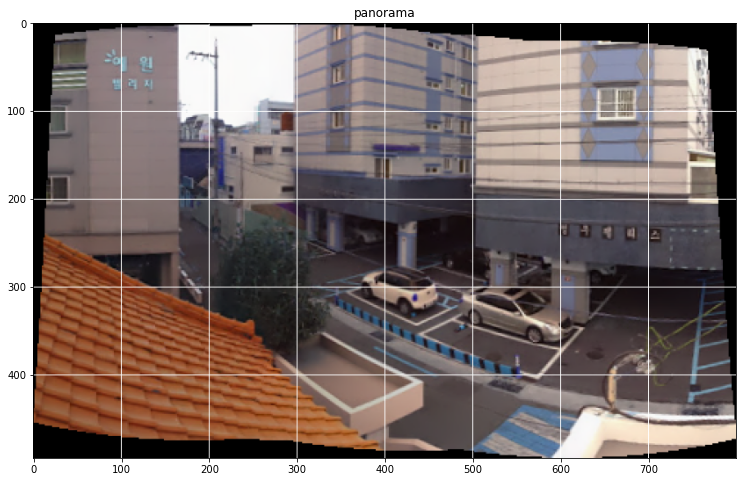

In [6]:
#stitcher = cv2.createStitcher()
#  AttributeError: module 'cv2.cv2' has no attribute 'createStitcher'
#
# It is probably because you are using OpenCV 4.
# If you are using OpenCV 4 you should use cv2.Stitcher_create() (also cv2.Stitcher.create() should work).
# If you are using OpenCV 3 you should use cv2.createStitcher() as you did.
stitcher = cv2.Stitcher_create()
#stitcher = cv2.Stitcher.create()


# Use stitcher to stitch the array of images
ret, pano = stitcher.stitch(images)
print(ret, pano.shape,cv2.STITCHER_OK)

if ret == cv2.STITCHER_OK:
    pano = imutils.resize(pano, width=800)
    plt_view_image(plt,[["panorama",draw_grid(np.copy(pano),100,(255,255,255))]],
                   figsize=(16,8), axis='on', cmap='gray')
    
    cv2.imshow('panorama', draw_grid(np.copy(pano),100,(255,255,255)))
    cv2.waitKey()

    cv2.destroyAllWindows()
else:
    print('Error during stitching')